In [1]:
import hashlib 
import os
import tarfile
import zipfile
import requests


"""
    第二和第七：https://www.bilibili.com/video/BV1rh411m7Hb?from=search&seid=14820697425740410884
    第三h2o：https://www.kaggle.com/wuwawa/automl-using-h2o
    第四 随机森林：https://www.kaggle.com/jackzh/the-4th-place-approach-random-forest

    经验：对于一个超参数可以微调看看影响大不大，如果大很可能是过拟合

    MLP可以看一下第一版的Kaggle竞赛

"""


DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


In [2]:
%matplotlib inline 
import numpy as np 
import pandas as pd 
import torch
from torch import nn
from d2l import torch as d2l 

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv', 
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',                         
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)


(1460, 81)
(1459, 80)


In [3]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]) # 打印前四行的前后三列

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [4]:
# 在每个样本中，第一列是ID，删除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])  # 打印前四行的前后三列


   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml


In [5]:
"""将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据"""
#找到所有数值列
# print(all_features.dtypes)
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()) # 均值0，方差1
)
all_features[numeric_features] = all_features[numeric_features].fillna(0) # out of number改为0（均值）

In [6]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.iloc[:, -5:])
all_features.shape


      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                        0                     0                     1   
1                        0                     0                     1   
2                        0                     0                     1   
3                        0                     0                     0   
4                        0                     0                     1   
...                    ...                   ...                   ...   
1454                     0                     0                     1   
1455                     0                     0                     0   
1456                     0                     0                     0   
1457                     0                     0                     1   
1458                     0                     0                     1   

      SaleCondition_Partial  SaleCondition_nan  
0                         0                  0  
1            

(2919, 331)

In [7]:
# 从pandas格式中提取NumPy格式，并转换为张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(
    all_features[:n_train].values,
    dtype=torch.float32
)
test_features = torch.tensor(
    all_features[n_train:].values,
    dtype=torch.float32
)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1),
    dtype=torch.float32
)

In [8]:
"""训练"""
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

我们更关心相对误差$ \frac{y - \hat{y}}{y} $，解决这个问题的一种方法是用价格预测的对数来衡量差异

In [9]:
"""我们更关心相对误差"""
def log_rmse(net, features, labels):
    # 将输入input的张量每个元素的夹紧到区间[min, max]，并返回结果到一个新张量
    # torch.clamp(input, min, max, out=None) -> Tensor
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [10]:
"""借助Adam优化器训练"""
"""
    Adam可以认为是一个比较平滑的SGD
    对学习率不太敏感

    weight_decay：权重衰减
"""
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [11]:
"""K折交叉验证"""
def get_k_fold_data(k, i, X, y): 
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k): 
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i: 
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [12]:
"""返回训练和验证误差的平均值"""
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        # 加*号，表示元组？
        # if i == 0: print(*data)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(
                list(range(1, num_epochs + 1)), 
                [train_ls, valid_ls], 
                xlabel='epoch', ylabel='rmse',
                xlim=[1, num_epochs], 
                legend=['train', 'valid'],
                yscale='log'
            )
        print(f'fold {i+1}, train log rmse {float(train_ls[-1]):f}',
                f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k


fold 1, train log rmse 0.170407 valid log rmse 0.156948
fold 2, train log rmse 0.164450 valid log rmse 0.183486
fold 3, train log rmse 0.165735 valid log rmse 0.171782
fold 4, train log rmse 0.168912 valid log rmse 0.156266
fold 5, train log rmse 0.162738 valid log rmse 0.183280
5-折验证：平均训练log rmse: 0.166448 平均验证log rmse: 0.170352


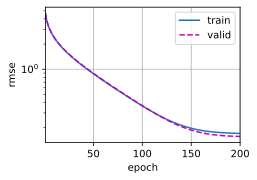

In [13]:
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 2, 0., 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                            weight_decay, batch_size)

print(f'{k}-折验证：平均训练log rmse: {float(train_l):f}',
      f'平均验证log rmse: {float(valid_l):f}')

train log rmse 0.162991


'\n k, num_epochs, lr, weight_decay, batch_size = 5, 120, 5, 0.01, 64\n 0.1558\n k, num_epochs, lr, weight_decay, batch_size = 5, 150, 5, 0.1, 64\n 0.1549（有点过拟合）\n'

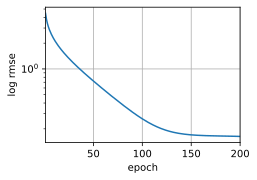

In [14]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                    num_epochs, lr, weight_decay, batch_size): 
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch', ylabel='log rmse',
                        xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
                num_epochs, lr, weight_decay, batch_size)
    
"""
 k, num_epochs, lr, weight_decay, batch_size = 5, 120, 5, 0.01, 64
 0.1558
 k, num_epochs, lr, weight_decay, batch_size = 5, 150, 5, 0.1, 64
 0.1549（有点过拟合）
"""
    
